# Quantum K-Nearest Neighbors: Utilizing QRAM and SWAP-Test Techniques for Enhanced Performance


## Classical algorithm

The classical K-NN classification algorithm, extensively utilized in supervised learning, relies on two datasets: a training set containing labeled samples and a test set consisting of unlabeled ones. To classify each test sample, the algorithm employs a similarity metric, typically a distance metric in feature space.


the classical algorithm is shown as an image and pseudocode:


<div style="background-color:#E2E2E2; padding:10px 0;font-family:monospace;">
<font color = "blue"><b>Classical K-NN</b></font><br>
    &nbsp;&nbsp;&nbsp;&nbsp; Designate a labeled training set and an unlabeled test set. <br> 
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the test set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the training set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Compute the distance between the test event and training event.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Find the K nearest neighbors to the test event.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; The class with the highest number of nearest neighbors is assigned to the test event.<br>
</div>

<img src="images/qknn_figure1.png" alt="example of K-NN" style=" height: 233px; width:621px;  display: block; margin-left: auto;   margin-right: auto;"  />

## Quantum proposal

### Dependencies 


This quantum algorithm uses qiskit, numpy, skelearn  and seaborn as dependencies to run the cide.

In [1]:
#!pip install tqdm

In [2]:
# import sklearn to load the iris dataset and split the dataset in train and test model, and the metric confusion matrix
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# import pandas to use seaborn plots as hue parameter
import pandas as pd

# import seaborn to plot the iris dataset
import seaborn as sns

# import numpy for postprocessing to find the k-nn label
import numpy as np

#module to find the mode
import operator

# import math methods
import math

#save data
import pickle

# import qiskit minimal methods to use quantum circuit and use qubits as the classical bits
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import CircuitInstruction, Instruction
from qiskit.circuit.library.standard_gates import CRYGate,RYGate,RZGate

#progress bar
from tqdm import tqdm

from qknn.functions import index_positions, diffuser, qram, oracle_st, qknn

# Dataset

Obtained  iris dataset from sklearn using dataset module. The iris dataset is used, which has 3 classes: **Iris-setosa**,**Iris-versicolor**,**Iris-virginica**, each with 50 instances, resulting in a total of 150.


In [3]:
iris = datasets.load_iris()
iris = datasets.load_wine()

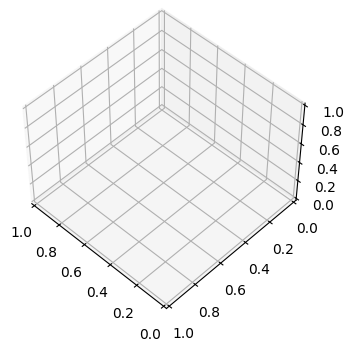

In [4]:
# Code source: Gaël Varoquaux
# License: BSD 3 clause

import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn import datasets, decomposition

np.random.seed(5)

iris = datasets.load_wine()
X = iris.data
y = iris.target

fig = plt.figure(1, figsize=(4, 3))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])


plt.cla()
f=8
pca = decomposition.PCA(n_components=f)
pca.fit(X)
X = pca.transform(X)

#X= 2*np.pi*(X-np.mean(X))/np.std(X)

iris["data"]=X

In [5]:
for i in range(f):

    X[:,[i]]  = 4*np.pi*X[:,[i]] /np.linalg.norm(X[:,[i]])
    print(min(X[:,[i]]),max(X[:,[i]]))


[-1.40666692] [2.79833835]
[-1.97779266] [4.2278108]
[-2.76864962] [3.0582887]
[-2.53644932] [2.73194198]
[-2.82842583] [3.24767305]
[-2.01326404] [3.70416771]
[-2.80580777] [3.29605969]
[-3.08208301] [3.40737484]


This dataset plot using Seaborn module, a dataframe is required to read the variables, denoted as 'var1', 'var2', 'var3', and 'var4', along with the 'class' for color differentiation. Additionally, the chosen color palette is 'Paired'. 

In [6]:
df_iris = pd.DataFrame(np.append(iris['data'],np.atleast_2d(iris['target']).T, axis=1))
#df_iris.columns =['var1', 'var2', 'var3', 'var4', "class"]
#sns.pairplot(df_iris,hue="class", diag_kind="hist", markers=["o", "s", "D"], palette="Paired")

The hold-out method is used, with a split of 70% for the training set and 30% for the test set.

In [7]:
x_train, x_test, y_train, y_test =train_test_split(iris['data'], iris['target'], train_size=0.7, test_size=0.3, random_state=13)

In [8]:
features = len(x_train[0])
features

8

In [9]:
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 124
Number of original test examples: 54


# The quantum algorithm

The QK-NN is based on three critical components: data storage in QRAM, the similarity metric from the SWAP-Test quantum circuit, and grouping both of those to allow Grover's algorithm to increase the probability of selecting states with higher similarity as shown in the following Pseudocode and Figure

<div style="background-color:#E2E2E2; padding:10px 0;font-family:monospace;">
<font color = "blue"><b>Quantum K-NN</b></font><br>
    &nbsp;&nbsp;&nbsp;&nbsp; Designate a labeled training set and an unlabeled test set.<br> 
    &nbsp;&nbsp;&nbsp;&nbsp; Apply angle encoding to the features of both datasets <br> 
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the test set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Load the training set into QRAM. <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Initialize the oracle qubit to the state $|-\rangle$ <br>
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; The class with the highest number of nearest neighbors is assigned to the test event.<br>
</div>

<img src="images/qknn_figure7.png">

#### initial variables for  a example

In [10]:
# size of the QRAM with 4 cells |00>, |01>, |10>, |11>
size_QRAM = 2

# lenght of the feautres of the QRAM
features = len(x_train[0])

##### Integer to binary

The first method using is generate a function to convert a integer value i na bin representation to qiskit, this  works to generate the control qubits needed for the QRAM

For example, the number 4 convert in 100, but the index position in a QRAM is 2 for the format q0q1q2, where q2 is  the position.

In [11]:
index_positions(4)

[2]

#### The diffuser

Is a quantum circuit used in Grover's algorithm that do a reflection operation to consider in this algorithm only the train state more similar with  the test set's instance

For example a diffuser of 3 qubits where using a mcx gate changed to mcz  with the equivalence HXH = Z.

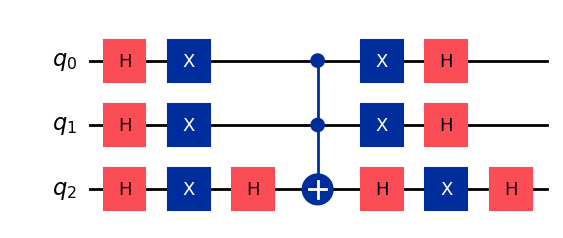

In [12]:
nqubits = 3
def example_diffuser(nqubits:int):
    qc_d = QuantumCircuit(nqubits)
    qc_d.append(diffuser(nqubits),range(nqubits))
    return qc_d
example_diffuser(nqubits).decompose().draw("mpl")

#### The QRAM and QRAM$^{\dagger}$ 


This is a method using a MCX to save the train set, the size must be $2^m$, $m$ is the number of qubits address. a And save the information in $n$ qubits features· 

For example a QRAM of 2 qubits address and the first four elements of iris train set.

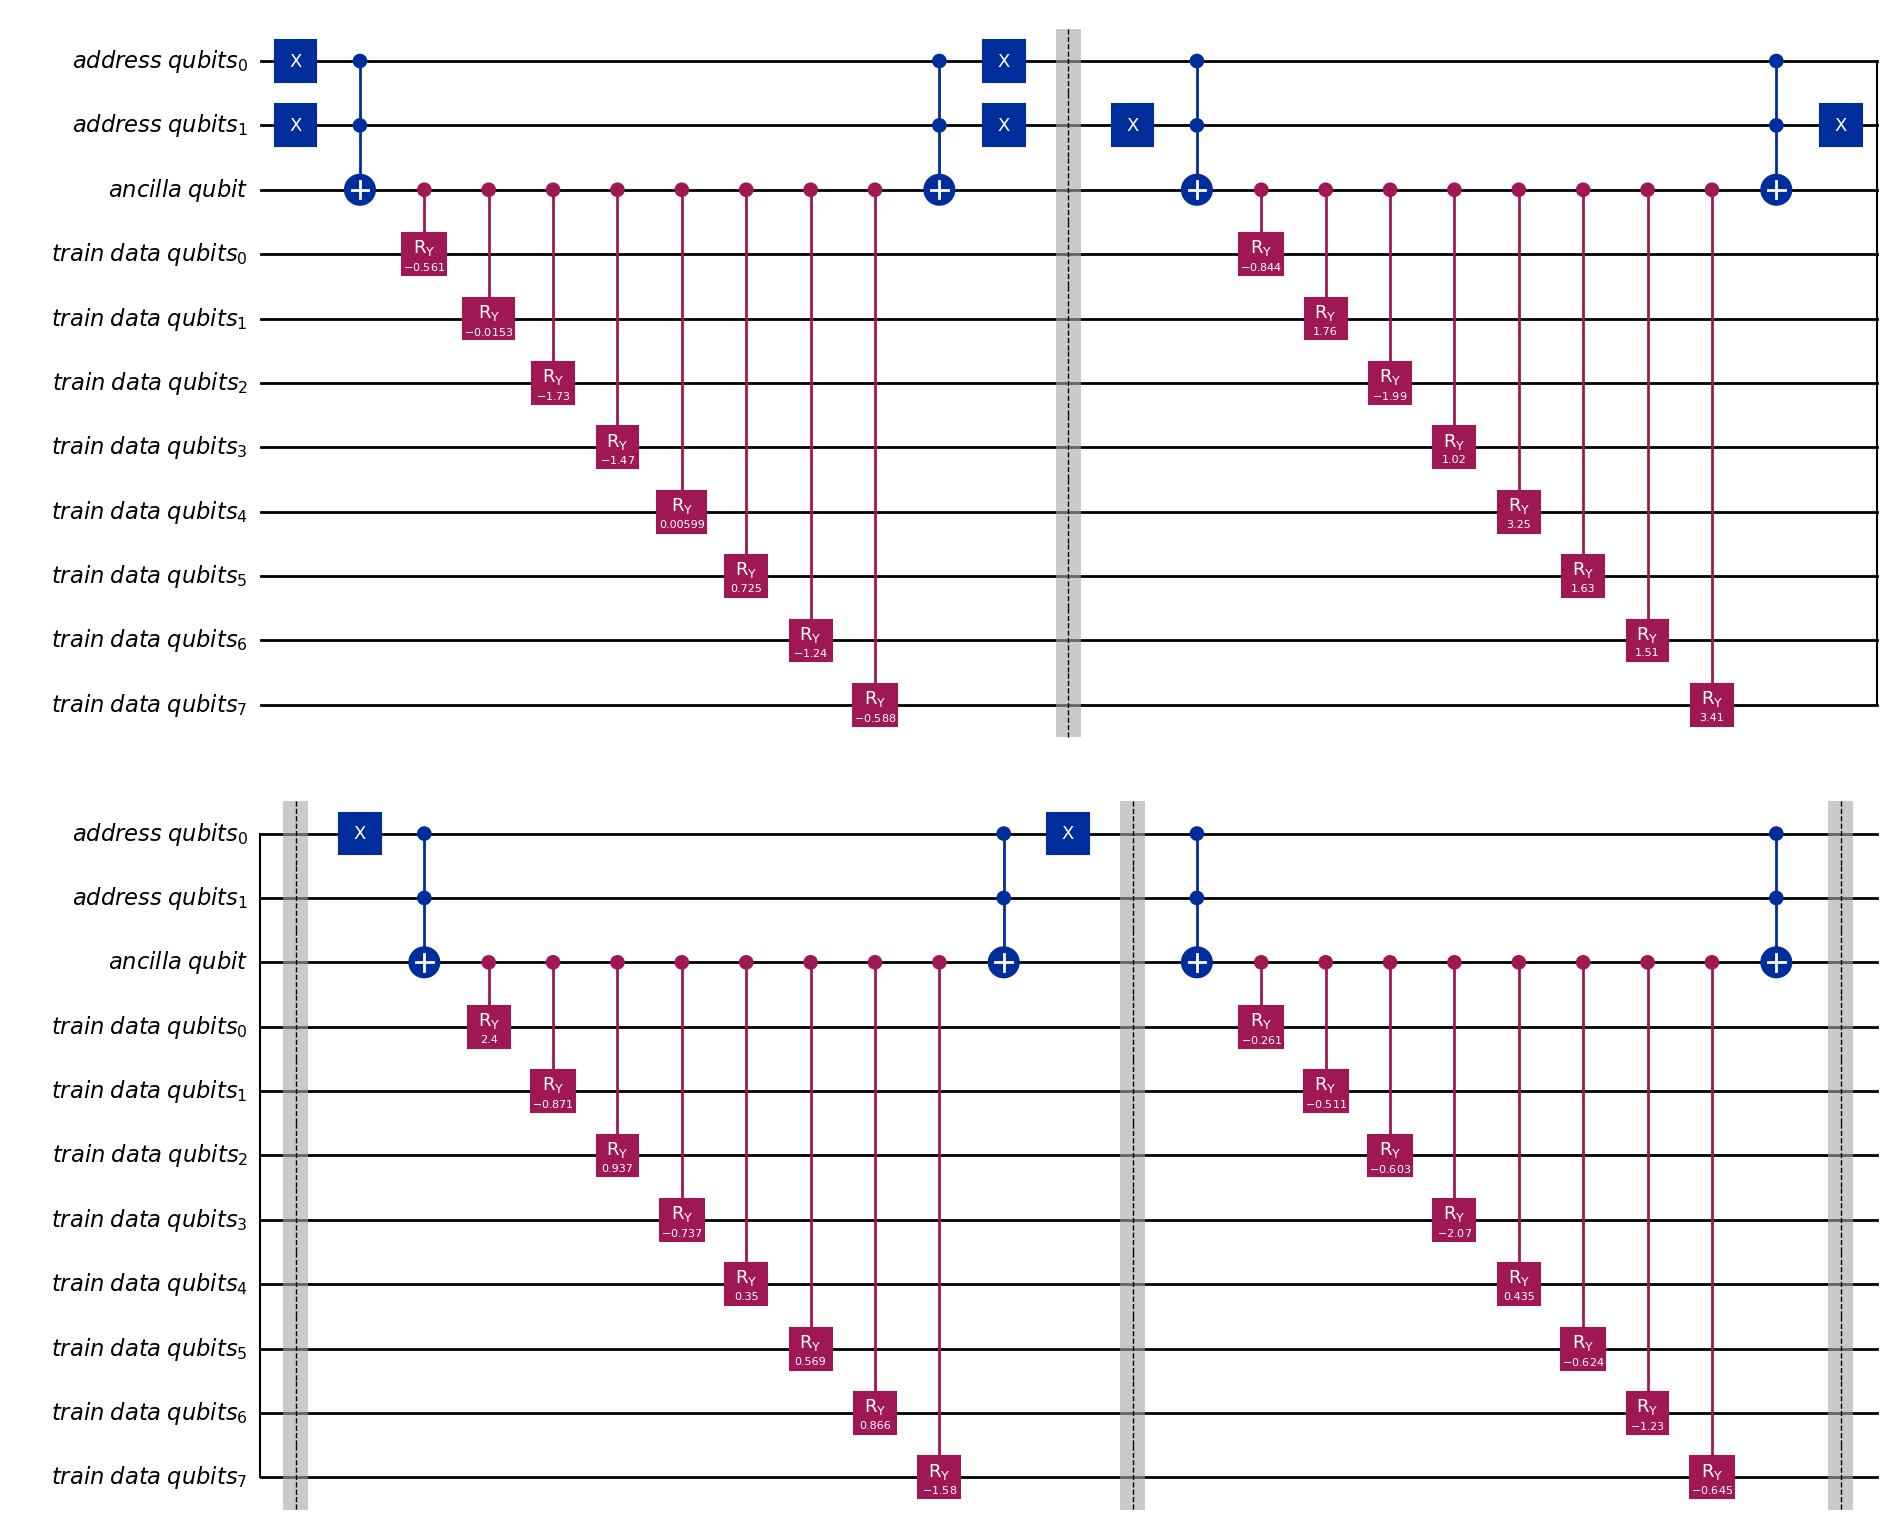

In [13]:
qram(size_QRAM,features,x_train[:4],RYGate).draw("mpl")

For example a QRAM$^{\dagger}$ of 2 qubits address and the first four elements of iris train set using the qiskit method **inverse()**.

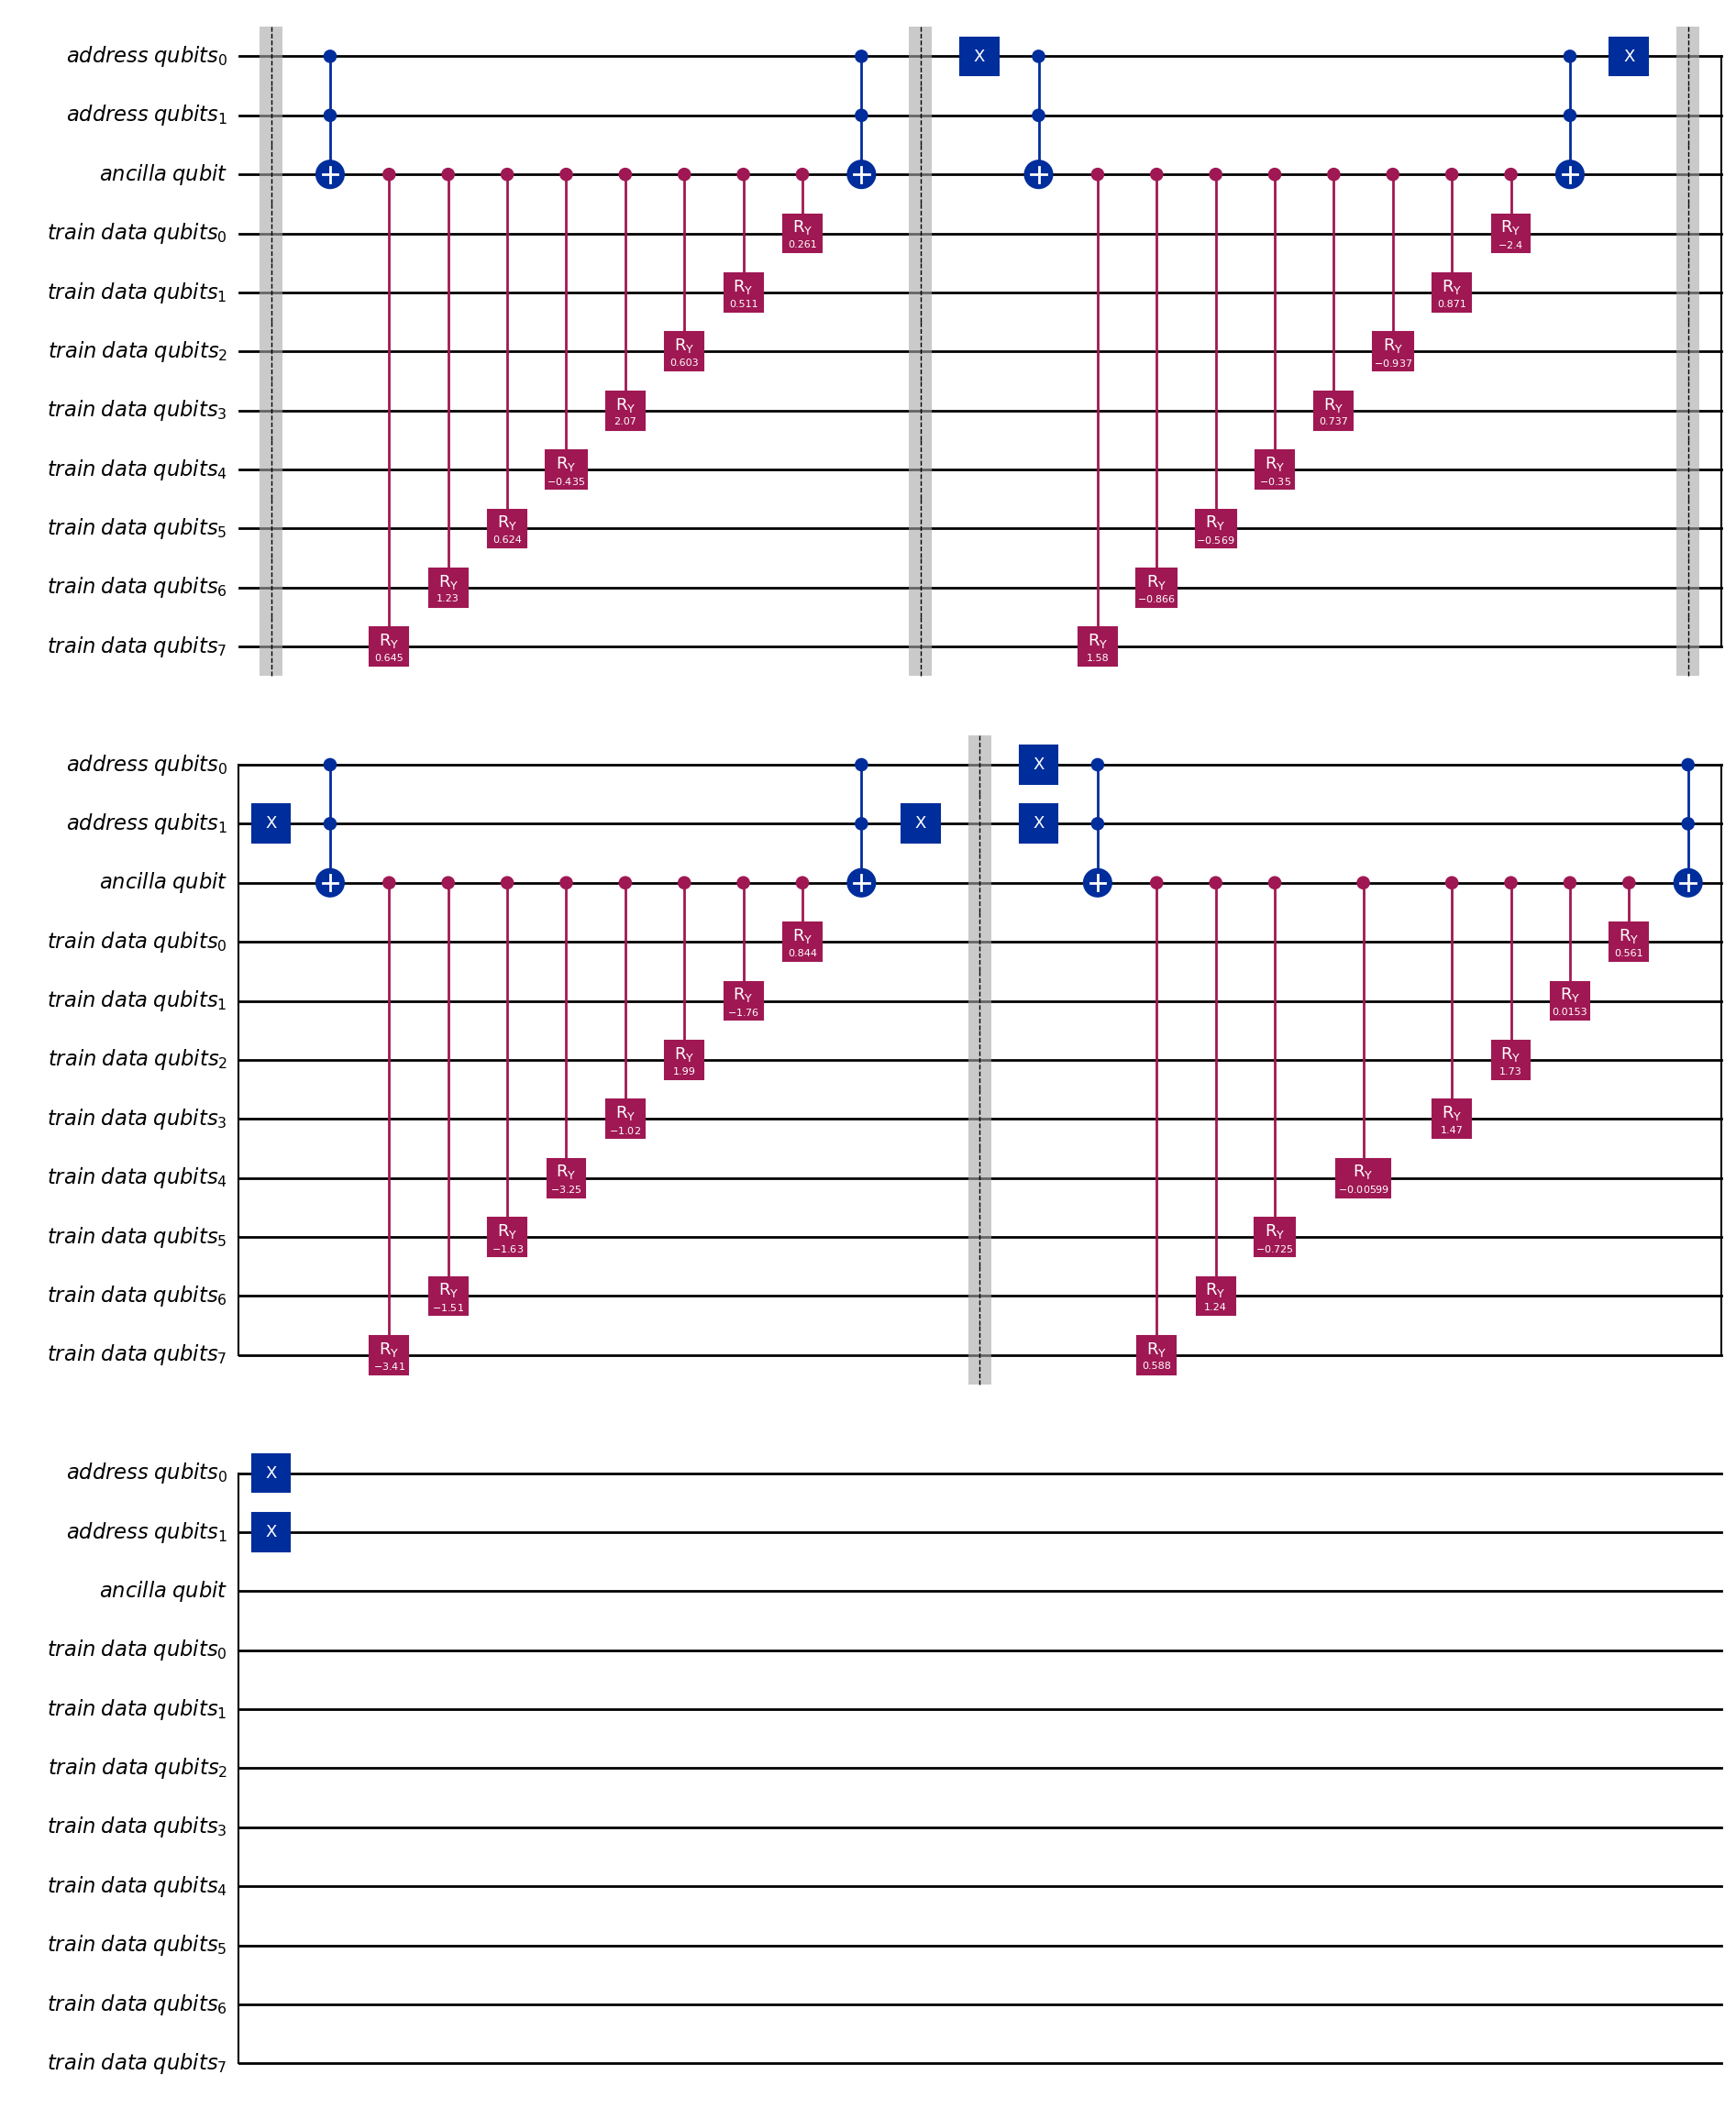

In [14]:
qram(size_QRAM,features,x_train[:4]).inverse().draw("mpl")

#### Oracle


Describes the oracle to check the similar state between the train set and the instance of the test set

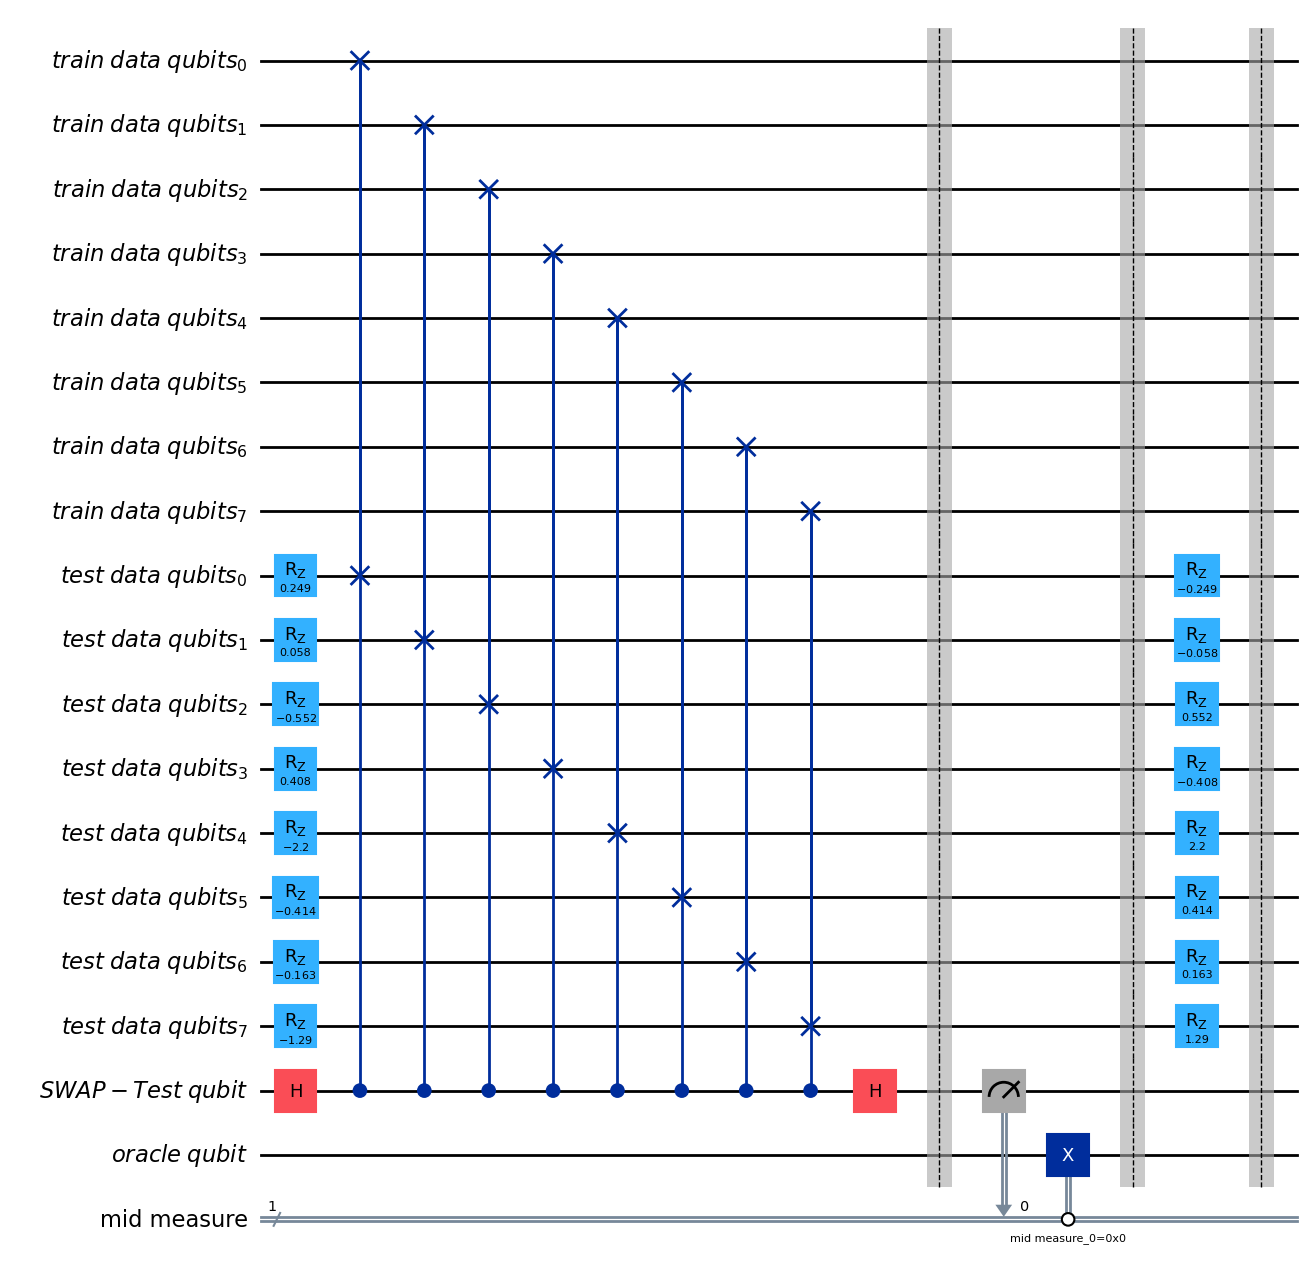

In [15]:
oracle_st(features,x_test[0],RZGate).draw("mpl")

#### Integrate all in a QK-NN quantum circuit

Using the previous function and the diagram to design the Quantum Circuit added the SWAP-Test with intermediate measurement that is activate when is the value 0.

Example with 2 qubits of the QK-NN of the first 4 features.

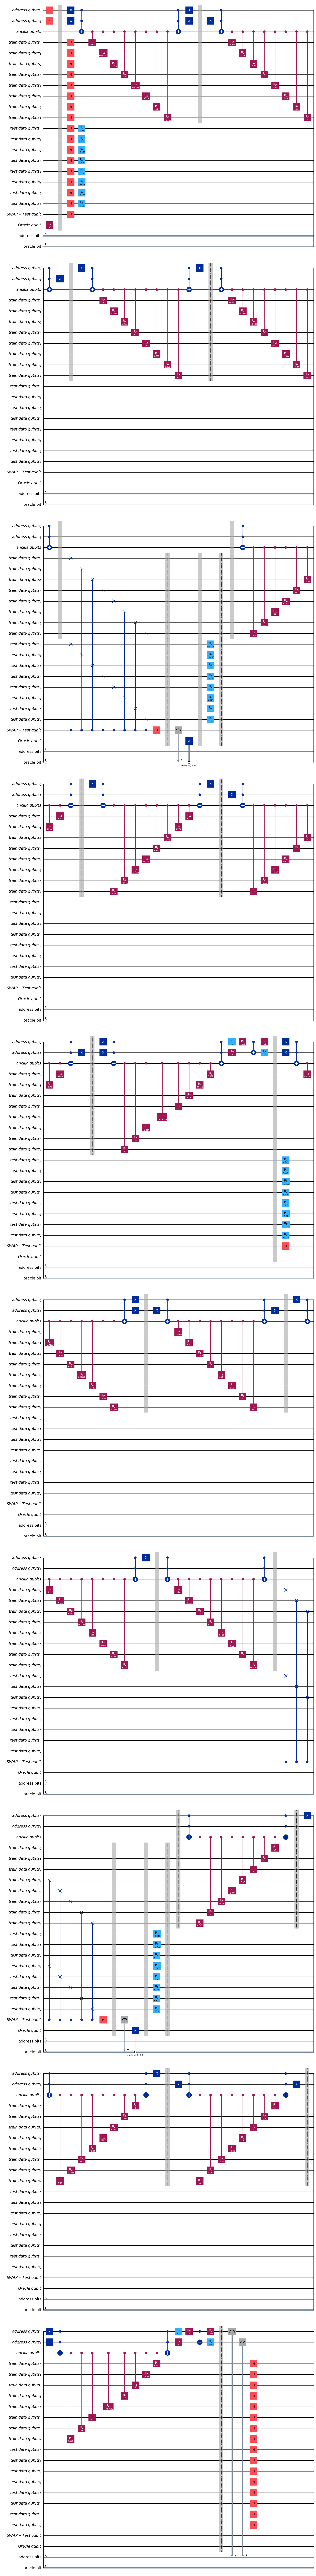

In [16]:
max_trials = 2
transpile(qknn(x_test[0], x_train,size_QRAM,features,max_trials,"rz"), basis_gates=[ 'cswap','cry','crz', 'barrier', 'h', 'measure', 'ccx', 'x', 'reset', 'rz', 'ry', 'snapshot', 'cx', 'delay']).draw("mpl")

### Experiments

Experiments of the QK-NN with size of QRAM of 8, 16, 32, 64, and 128 cells of memory.

In [23]:
class qknn_experiments():
    """
    Class to use multiple knn experiments
    """
    
    def __init__(self,x_test:list=[[1]],
                    x_train:list=[[1]],
                    y_test:list=[[1]],
                    y_train:list=[[1]],
                    features:int=1,
                    max_trials:int=1,
                    rotation:str="ry",
                    experiment_size:int=1,
                   min_QRAM:int=3,
                    max_QRAM:int=4):
        self.x_test = x_test
        self.x_train = x_train
        self.y_test = y_test
        self.y_train = y_train
        self.features = features
        self.max_trials = max_trials
        self.rotation = rotation
        self.experiment_size = experiment_size
        self.min_QRAM = min_QRAM
        self.max_QRAM = max_QRAM
        self.size_test_set = len(self.y_test)

        self.acc_8 = []
        self.acc_16 = []
        self.acc_32 = []
        self.acc_64 = []
        self.acc_128 = []


    def experiments_knn(self,k:int = 1,shots:int =10000):
        for _ in tqdm(range(self.experiment_size)):
            for size in range(self.min_QRAM,self.max_QRAM):
                y_pred = []

                for i in range(self.size_test_set):
                    qc = qknn(self.x_test[i], self.x_train,size,self.features,self.max_trials,self.rotation)
                    result = AerSimulator().run(transpile(qc,basis_gates=["cx","rz","x","sx"],optimization_level=3), shots=shots).result()
                    counts = result.get_counts(qc)
                    counts = {a: v for a, v in sorted(counts.items(), key=lambda item: item[1],reverse=True)}
                    
                    values = list(counts.keys())
                    index = 0 
                    neighbors = {}
                    while index < k:
                        if values[index][0] == "1":
                            k_class = y_train[int(values[index][2:],2)]
                            if k_class in neighbors:
                                neighbors[k_class] = neighbors[k_class]+1
                            else:
                                neighbors[k_class] = 1
                            index += 1
                        else:
                            del values[index]
                                
                    knn = {a: v for a, v in sorted(neighbors.items(), key=lambda item: item[1],reverse=True)}
                    y_pred.append(next(iter(knn)))

                
                acc_knn = accuracy_score(self.y_test,y_pred)*100
                if size == 3:
                    self.acc_8.append(acc_knn)
        
                elif size == 4:
                    self.acc_16.append(acc_knn)
        
                elif size == 5:
                    self.acc_32.append(acc_knn)
        
                elif size == 6:
                    self.acc_64.append(acc_knn)
                    
                elif size == 7:
                    self.acc_128.append(acc_knn)
        
    
        return self.acc_8,self.acc_16,self.acc_32,self.acc_64,self.acc_128


    def set_rotation(self,rotation:str="ry"):
        self.rotation = rotation
    
    def draw_qknn(self,index:int=0,size:int=3):
        return qknn(self.x_test[index], self.x_train,size,self.features,self.max_trials,self.rotation)

    
    def mae_acc(self,acc:list):
        mean =  np.mean(np.asarray(acc))
        n = len(acc)
        summ = 0
        for i in range(n):
            summ += abs(mean - acc[i])
        return mean,summ/n
    
    def print_results(self):
        print("The MAE value of each size is ")
        for i in range(self.min_QRAM,self.max_QRAM):
            mean,error = 0,0
            if i == 3:
                mean,error  = self.mae_acc(self.acc_8)
            elif i == 4:
                mean,error  = self.mae_acc(self.acc_16)
            elif i == 5:
                mean,error  = self.mae_acc(self.acc_32)
            elif i == 6:
                mean,error  = self.mae_acc(self.acc_64)
            elif i == 7:
                mean,error  = self.mae_acc(self.acc_128)
                
            print(f'MAE of  QRAM of size {int(2**i)} cells of memory with {mean:.2f} +/- {error:.2f}.')


###  Results

#### RY

100%|█████████████████████████████████████████████| 1/1 [01:09<00:00, 69.56s/it]


([50.0], [], [], [], [])
The MAE value of each size is 
MAE of  QRAM of size 8 cells of memory with 50.00 +/- 0.00.


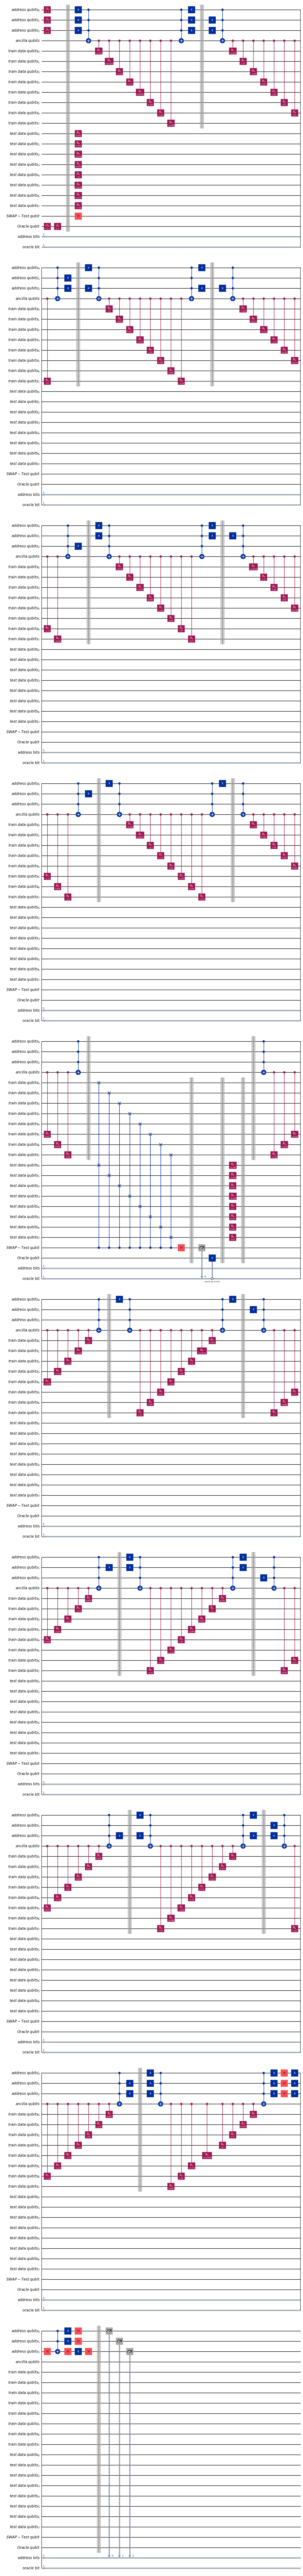

In [24]:
experiment_size = 1
min_QRAM = 3
max_QRAM = 4
qknn_e = qknn_experiments(
    x_test=x_test,#x_test=[[0,0,0,0],[0,0,0,0]],#x_test=x_test,
    x_train=x_train,#x_train=[[0,0,0,0],[np.pi,np.pi,np.pi,np.pi],[0,0,0,np.pi],[np.pi,np.pi,np.pi,np.pi],[np.pi,np.pi,np.pi,np.pi],[np.pi,np.pi,np.pi,np.pi],[np.pi,np.pi,np.pi,np.pi],[np.pi,np.pi,np.pi,np.pi]],#x_train=x_train,
    y_test=y_test,#y_test=[0,0],#y_test=y_test,
    y_train=y_train,#y_train=[0,1,0,1,1,1,1,1],
    features=features,
    min_QRAM=min_QRAM,
    max_QRAM=max_QRAM,
    max_trials=1,
    rotation="ry",
    experiment_size=experiment_size)

print(qknn_e.experiments_knn(k=5))
qknn_e.print_results()
qknn_e.draw_qknn(0).decompose().draw("mpl")

#### RZ

100%|████████████████████████████████████████████| 1/1 [05:12<00:00, 312.32s/it]


([46.2962962962963], [81.48148148148148], [], [], [])
The MAE value of each size is 
MAE of  QRAM of size 8 cells of memory with 46.30 +/- 0.00.
MAE of  QRAM of size 16 cells of memory with 81.48 +/- 0.00.


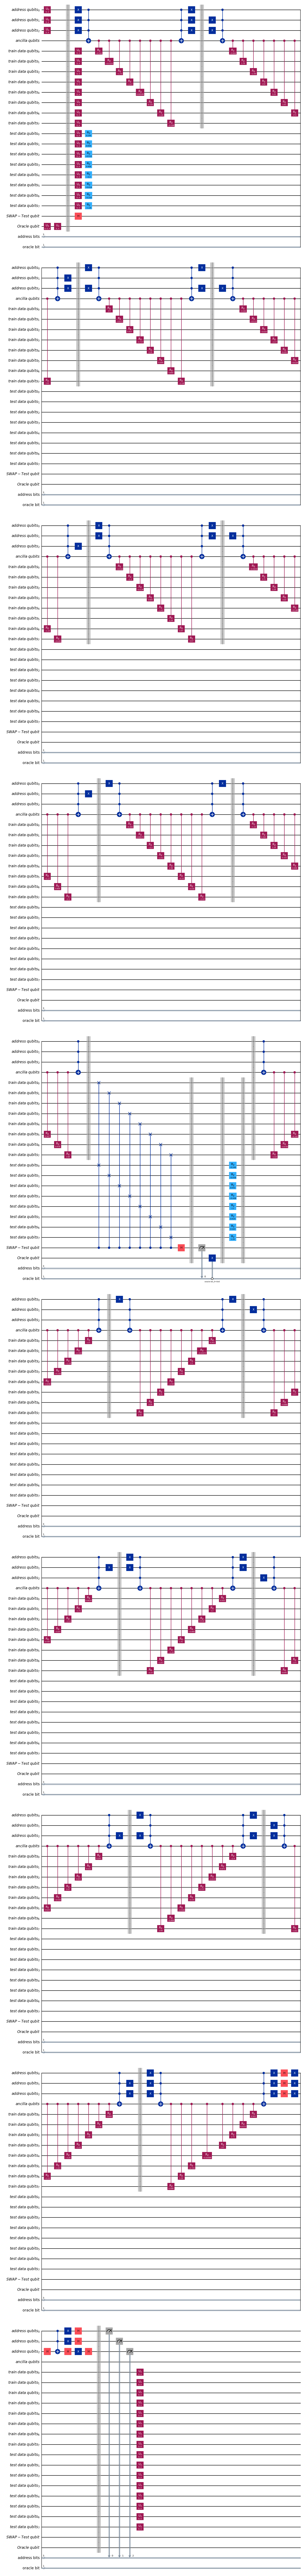

In [25]:
experiment_size = 1
min_QRAM = 3
max_QRAM = 5
qknn_e = qknn_experiments(
    x_test=x_test,#x_test=[[0,0,0,0],[0,0,0,0]],#x_test=x_test,
    x_train=x_train,#x_train=[[0,0,0,0],[np.pi,np.pi,np.pi,np.pi],[0,0,0,np.pi],[np.pi,np.pi,np.pi,np.pi],[np.pi,np.pi,np.pi,np.pi],[np.pi,np.pi,np.pi,np.pi],[np.pi,np.pi,np.pi,np.pi],[np.pi,np.pi,np.pi,np.pi]],#x_train=x_train,
    y_test=y_test,#y_test=[0,0],#y_test=y_test,
    y_train=y_train,#y_train=[0,1,0,1,1,1,1,1],
    features=features,
    min_QRAM=min_QRAM,
    max_QRAM=max_QRAM,
    max_trials=1,
    rotation="rz",
    experiment_size=experiment_size)

print(qknn_e.experiments_knn(k=5))
qknn_e.print_results()
qknn_e.draw_qknn(0).decompose().draw("mpl")